Command line interface
====================

xclim provides the  `xclim` command line executable to perform basic indicator
computation easily without having to start up a full python environment. However, not
all indicators listed in [Climate Indicators](../indicators.rst) are available through this tool.

Its use is simple. Type the following to see the usage message:

In [1]:
!xclim --help

Usage: xclim [OPTIONS] INDICATOR1 [OPTIONS] ... [INDICATOR2 [OPTIONS] ... ]
             ...

  Command line tool to compute indices on netCDF datasets

Options:
  -i, --input TEXT           Input files. Can be a netCDF path or a glob
                             pattern.
  -o, --output TEXT          Output filepath. A new file will be created
  -v, --verbose              Make it more verbose
  --tas-from <TEXT TEXT>...  Variable names in the input dataset for 'tasmin'
                             and 'tasmax', used when 'tas' is needed but
                             absent from the dataset
  --version                  Prints xclim's version number and exits
  --dask-nthreads INTEGER    Start a dask.distributed Client with this many
                             threads and 1 worker. If not specified, the local
                             schedular is used. If specified, '--dask-maxmem'
                             must also be given
  --dask-maxmem TEXT         Memory limit for the 

To list all available indicators, use the "indices" subcommand:

In [2]:
!xclim indices

Listing all available indicators for computation.:

Indicators in module atmos:
  rain_on_frozen_ground_days (rain_frzgr)
                                  Number of rain on frozen ground days
  max_1day_precipitation_amount (rx1day)
                                  maximum 1-day total precipitation
  wetdays                         Number of wet days (precip >= {thresh})
  maximum_consecutive_dry_days (cdd)
                                  Maximum consecutive dry days (Precip <
                                  {thresh})
  maximum_consecutive_wet_days (cwd)
                                  Maximum consecutive wet days (Precip >=
                                  {thresh})
  precip_accumulation (prcptot)   Total precipitation
  liquid_precip_accumulation (liquidprcptot)
                                  Total liquid precipitation
  solid_precip_accumulation (solidprcptot)
                                  Total solid precipitation
  tn_days_below                   Number of days wit

For more information about a specific indicator, you can either use the `info` subcommand or directly access the `--help` message of the indicator. The former gives more information about the metadata while the latter only prints the usage. Note that the module name (`atmos`, `land` or `seaIce`) is mandatory.

In [3]:
!xclim info atmos.liquid_precip_accumulation 

Indicator atmos.liquid_precip_accumulation:
  identifier: liquidprcptot
  var_name: liquidprcptot
  title: Accumulated total (liquid and/or solid) precipitation.
  long_name: Total liquid precipitation
  units: mm
  cell_methods: time: sum within days time: sum over days
  abstract: Resample the original daily mean precipitation flux and
  accumulate over each period. If the daily mean temperature is provided,
  the phase keyword can be used to only sum precipitation of a certain
  phase. When the mean temperature is over 0 degC, precipitatio is assumed
  to be liquid rain and snow otherwise.
  description: {freq} total liquid precipitation, estimated as
  precipitation when daily average temperature >= 0°C

Options:
  --pr VAR_NAME   Mean daily precipitation flux [Kg m-2 s-1] or [mm].
                  [default: pr]
  --tas VAR_NAME  Mean daily temperature [℃] or [K]  [default: None]
  --phase TEXT    Which phase to consider, "liquid" or "solid", if None
                  (default), b

In the usage message, `VAR_NAME` indicates that the passed argument must match a variable in the input dataset.

In [4]:
import xarray as xr
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings('ignore', 'implicitly registered datetime converter')
%matplotlib inline
xr.set_options(display_style='html')

time = pd.date_range('2000-01-01', periods=366)
tasmin = xr.DataArray(-5 * np.cos(2 * np.pi * time.dayofyear / 365) + 273.15, dims=("time"), 
                      coords={'time': time}, attrs={'units':'K'})
tasmax = xr.DataArray(-5 * np.cos(2 * np.pi * time.dayofyear / 365) + 283.15, dims=("time"),
                      coords={'time': time}, attrs={'units':'K'})
pr = xr.DataArray(np.clip(10 * np.sin(18 * np.pi * time.dayofyear / 365), 0, None), dims=("time"),
                      coords={'time': time}, attrs={'units':'mm/d'})
ds = xr.Dataset({'tasmin': tasmin, 'tasmax': tasmax, 'pr': pr})
ds.to_netcdf('example_data.nc')

Computing indicators
-------------------------------

So let's say we have the following toy dataset:

In [5]:
import xarray as xr
ds = xr.open_dataset('example_data.nc')
ds

<xarray.Dataset>
Dimensions:  (time: 366)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
Data variables:
    tasmin   (time) float64 ...
    tasmax   (time) float64 ...
    pr       (time) float64 ...

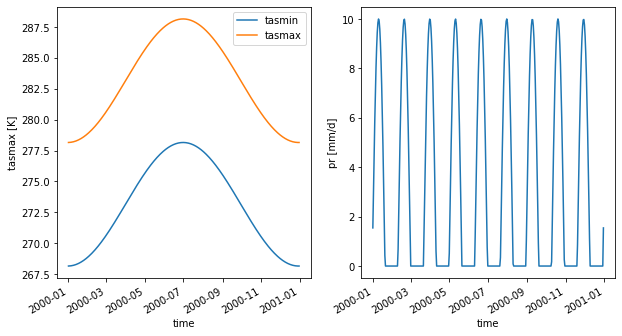

In [6]:
import matplotlib.pyplot as plt
fig, (axT, axpr) = plt.subplots(1, 2, figsize=(10, 5))
ds.tasmin.plot(label='tasmin', ax=axT)
ds.tasmax.plot(label='tasmax', ax=axT)
ds.pr.plot(ax=axpr)
axT.legend()

To compute an indicator, say the monthly solid precipitation accumulation, we simply call:

In [15]:
!xclim -i example_data.nc -o out1.nc atmos.solid_precip_accumulation --pr pr --tas tasmax --freq MS

Processing : Total solid precipitation
Parsing pr = pr
<xarray.DataArray 'pr' (time: 366)>
dask.array<open_dataset-f0127628850902a19dffa4f22f8fd2fapr, shape=(366,), dtype=float64, chunksize=(366,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
Attributes:
    units:    mm/d
Parsing tas = tasmax
<xarray.DataArray 'tasmax' (time: 366)>
dask.array<open_dataset-f0127628850902a19dffa4f22f8fd2fatasmax, shape=(366,), dtype=float64, chunksize=(366,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
Attributes:
    units:    K
Parsing freq = MS
Parsing phase = None
Writing everything to file out1.nc
[########################################] | 100% Completed |  0.1s


In this example, we decided to use `tasmin` for the `tas` variable. We didn't need to provide the `--pr` parameter as our data has the same name. 

<div class="alert alert-info">
    
As it is a common case that climate datasets provide `tasmin` and  `tasmax`, but not `tas`, the command line makes it simple and accepts the `--tas-from` keyword. It then computes the simple mean on the fly. 

</div>

Finally, more than one indicators can be computed to the output dataset by simply chaining the calls:

In [8]:
!xclim -i example_data.nc -o out2.nc --tas-from tasmin tasmax atmos.liquid_precip_accumulation --freq MS atmos.tropical_nights --thresh "2 degC" --freq MS

Processing : Total liquid precipitation
Processing : Number of Tropical Nights (Tmin > 2 degC)
Writing everything to file out2.nc
[########################################] | 100% Completed |  0.1s


Let's see the outputs:

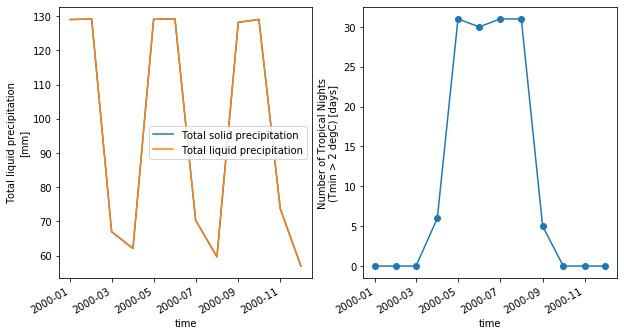

In [9]:
ds1 = xr.open_dataset('out1.nc')
ds2 = xr.open_dataset('out2.nc', decode_times=False)
ds2['time'] = xr.decode_cf(ds2).time

fig, (axPr, axTn) = plt.subplots(1, 2, figsize=(10, 5))
ds1.solidprcptot.plot(ax=axPr, label=ds1.solidprcptot.long_name)
ds2.liquidprcptot.plot(ax=axPr, label=ds2.liquidprcptot.long_name)
ds2.tropical_nights.plot(ax=axTn, marker='o')
axPr.legend()

In [10]:
ds1.close()

In [11]:
ds2.close()